# LSTM for stock prediction

## Import Library

In [ ]:
!sudo pip install torch==2.0.0 pandas numpy tqdm matplotlib

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm

from typing import Any, Dict, List, Tuple

import os
import csv

In [127]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Constants Definition

In [128]:
EXTENDED_FEATURES = [
]
NORMALIZED_FEATURE = [
    'imbalance_size',
    'matched_size',
    'bid_size',
    'ask_size'
]
FILL_ONE_FEATURES = [
    "reference_price", 
    "far_price",
    "near_price",
    "bid_price",
    "ask_price",
    "wap"
]
FILL_MEAN_FEATURES = [
    "imbalance_size", 
    "matched_size"
]
MODEL_INPUT_FEATURES = [
    'imbalance_size', 
    'imbalance_buy_sell_flag',
    'reference_price',
    'matched_size',
    'far_price',
    'near_price',
    'bid_price',
    'bid_size',
    'ask_price',
    'ask_size',
    'wap',
    'target'
]

## Hyper Parameters

In [153]:
BATCH_SIZE: int = 256
EPOCHS: int = 300
LEARNING_RATE: float = 0.000005

## Import Dataset

In [130]:
kaggle_dir = './kaggle'
df = pd.read_csv(os.path.join(kaggle_dir, 'train.csv'))
df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [6]:
df.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [7]:
def inspect_columns(df):

    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })
    return result

inspect_columns(df)

,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
stock_id,False,200,False,0.00,0,181,199,int64
date_id,False,481,False,0.00,0,27,480,int64
seconds_in_bucket,False,55,False,0.00,0,410,540,int64
imbalance_size,False,2971863,True,0.00,3180602.69,2400918.36,1884285.71,float64
imbalance_buy_sell_flag,False,3,False,0.00,1,-1,-1,int64
reference_price,False,28741,True,0.00,0.999812,0.997309,1.002129,float64
matched_size,False,2948862,True,0.00,13380276.64,9135345.31,24073677.32,float64
far_price,False,95739,True,55.26,NaN,0.898997,1.000859,float64
near_price,False,84625,True,54.55,NaN,0.979654,1.001494,float64
bid_price,False,28313,True,0.00,0.999812,0.997309,1.002129,float64


## Data Splitting

In [131]:
train_df: pd.DataFrame = df.loc[(0 <= df['date_id']) & (df['date_id'] <= 399)]
valid_df: pd.DataFrame = df.loc[(400 <= df['date_id']) & (df['date_id'] <= 477)]
test_df: pd.DataFrame = df.loc[((477 == df['date_id']) & (500 <= df['seconds_in_bucket'])) | ((478 <= df['date_id']) & (df['date_id'] <= 480))]

print(f'The shape of train_df = {train_df.shape}')
print(f'The shape of valid_df = {valid_df.shape}')
print(f'The shape of test_df = {test_df.shape}')

The shape of train_df = (4346980, 17)
The shape of valid_df = (858000, 17)
The shape of test_df = (34000, 17)


## Data Preprocessing After Splitting

### Training Set

In [132]:
def GenPreprocessInfo(raw_df: pd.DataFrame) -> Dict[int, Dict[str, Dict[str, float]]]:
    '''
    Return value example:
    {
        'STOCK_ID': {
            'COLUMN': {
                'min': 0.0,
                'max': 1.0,
                'mean': 0.5
            }
        }
    }
    '''
    data: pd.DataFrame = raw_df.copy()
    statistic_result: Dict[int, Dict[str, Dict[str, float]]] = {}
    
    for stock in data['stock_id'].unique().tolist():
        stock_df: pd.DataFrame = data.loc[data['stock_id'] == stock]
        stock_info: Dict[str, Dict[str, float]] = {}
        
        for feat in stock_df.columns:
            if pd.api.types.is_string_dtype(stock_df[feat]):
                continue
            stock_feat_info: Dict[str, float] = {}
            stock_feat_info['min'] = stock_df[feat].min(skipna=True)
            stock_feat_info['max'] = stock_df[feat].max(skipna=True)
            stock_feat_info['mean'] = stock_df[feat].mean(skipna=True)
            stock_info[feat] = stock_feat_info
        
        statistic_result[stock] = stock_info
    
    return statistic_result

preprocess_info = GenPreprocessInfo(raw_df=train_df)

In [10]:
def PreprocessTrainSet(
    raw_df: pd.DataFrame, statistic_result: Dict[int, Dict[str, Dict[str, float]]]
) -> pd.DataFrame:
    
    data: pd.DataFrame = raw_df.copy()
    
    # fill out NaN with mean value
    for stock in data['stock_id'].unique().tolist():
        for feat in FILL_MEAN_FEATURES:
            data.loc[
                (data['stock_id'] == stock) & (data[feat].isnull()), 
                feat
            ] = statistic_result[stock][feat]['mean']

    # fill out NaN with 1
    for feat in FILL_ONE_FEATURES:
        data[feat] = data[feat].fillna(1.0)

    # normalize features
    for feat in MODEL_INPUT_FEATURES:
        if feat not in NORMALIZED_FEATURE:
            continue
        data['min'] = np.nan
        data['max'] = np.nan
        
        for stock in data['stock_id'].unique().tolist():
            data.loc[data['stock_id'] == stock, ['min', 'max']] = [
                statistic_result[stock][feat]['min'],
                statistic_result[stock][feat]['max']
            ]
        
        data[feat] = (data[feat] - data['min']) / (data['max'] - data['min'])
        data = data.drop('min', axis=1)
        data = data.drop('max', axis=1)
        
    data.dropna(inplace=True)
    
    print(f'Data has nan: \n{data.isnull().any()}')
    
    return data


train_pp_df = PreprocessTrainSet(raw_df=train_df, statistic_result=preprocess_info)

print(train_pp_df)

Data has nan: 
stock_id                   False
date_id                    False
seconds_in_bucket          False
imbalance_size             False
imbalance_buy_sell_flag    False
reference_price            False
matched_size               False
far_price                  False
near_price                 False
bid_price                  False
bid_size                   False
ask_price                  False
ask_size                   False
wap                        False
target                     False
time_id                    False
row_id                     False
dtype: bool
         stock_id  date_id  seconds_in_bucket  imbalance_size  \
0               0        0                  0        0.023833   
1               1        0                  0        0.014830   
2               2        0                  0        0.015351   
3               3        0                  0        0.037858   
4               4        0                  0        0.005779   
...           ...     

### Validation Set and Test Set

In [41]:
def PreprocessValidationTestSet(
    raw_df: pd.DataFrame, statistic_result: Dict[int, Dict[str, Dict[str, float]]]
) -> pd.DataFrame:

    data: pd.DataFrame = raw_df.copy()
    
    # fill out NaN with mean value
    for stock in data['stock_id'].unique().tolist():
        for feat in FILL_MEAN_FEATURES:
            data.loc[
                (data['stock_id'] == stock) & (data[feat].isnull()), 
                feat
            ] = statistic_result[stock][feat]['mean']

    # fill out NaN with 1
    for feat in FILL_ONE_FEATURES:
        data[feat] = data[feat].fillna(1.0)

    # normalize features
    for feat in MODEL_INPUT_FEATURES:
        if feat not in NORMALIZED_FEATURE:
            continue
        data['min'] = np.nan
        data['max'] = np.nan
        
        for stock in data['stock_id'].unique().tolist():
            data.loc[data['stock_id'] == stock, ['min', 'max']] = [
                statistic_result[stock][feat]['min'],
                statistic_result[stock][feat]['max']
            ]
        
        data[feat] = (data[feat] - data['min']) / (data['max'] - data['min'])
        data = data.drop('min', axis=1)
        data = data.drop('max', axis=1)
        
    data.dropna(inplace=True)
    
    print(f'Data has nan: \n{data.isnull().any()}')
    
    return data

In [12]:
valid_pp_df = PreprocessValidationTestSet(raw_df=valid_df, statistic_result=preprocess_info)
valid_pp_df

Data has nan: 
stock_id                   False
date_id                    False
seconds_in_bucket          False
imbalance_size             False
imbalance_buy_sell_flag    False
reference_price            False
matched_size               False
far_price                  False
near_price                 False
bid_price                  False
bid_size                   False
ask_price                  False
ask_size                   False
wap                        False
target                     False
time_id                    False
row_id                     False
dtype: bool


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
4346980,0,400,0,0.104640,1,0.999454,0.026447,1.000000,1.000000,0.999648,0.001736,1.000521,0.015102,1.000000,0.050068,22000,400_0_0
4346981,1,400,0,0.178324,1,0.998651,0.025849,1.000000,1.000000,0.998065,0.049754,1.002580,0.045598,1.000000,-10.010004,22000,400_0_1
4346982,2,400,0,0.097252,-1,1.000470,0.011749,1.000000,1.000000,0.999974,0.007547,1.001236,0.103731,1.000000,7.070303,22000,400_0_2
4346983,3,400,0,0.020171,1,1.000143,0.032162,1.000000,1.000000,0.999964,0.004982,1.000731,0.153409,1.000000,3.780127,22000,400_0_3
4346984,4,400,0,0.071687,1,0.999428,0.008230,1.000000,1.000000,0.999255,0.016142,1.000119,0.004565,1.000000,1.590252,22000,400_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5204975,195,477,540,0.040944,-1,1.002359,0.120353,1.001253,1.001253,1.002359,0.153837,1.002482,0.318110,1.002429,-3.190041,26289,477_540_195
5204976,196,477,540,0.045124,-1,0.998663,0.148910,0.996644,0.997401,0.998663,0.078859,0.999168,0.079631,0.998803,-6.200075,26289,477_540_196
5204977,197,477,540,0.004787,1,0.997623,0.024257,0.998388,0.998388,0.997240,0.013190,0.997623,0.033533,0.997405,0.000000,26289,477_540_197
5204978,198,477,540,0.027363,-1,0.999832,0.054122,0.998511,0.998751,0.999712,0.249313,0.999952,0.303272,0.999797,1.300573,26289,477_540_198


In [133]:
test_pp_df = PreprocessValidationTestSet(raw_df=test_df, statistic_result=preprocess_info)
test_pp_df

Data has nan: 
stock_id                   False
date_id                    False
seconds_in_bucket          False
imbalance_size             False
imbalance_buy_sell_flag    False
reference_price            False
matched_size               False
far_price                  False
near_price                 False
bid_price                  False
bid_size                   False
ask_price                  False
ask_size                   False
wap                        False
target                     False
time_id                    False
row_id                     False
dtype: bool


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5203980,0,477,500,0.010121,-1,0.998733,0.149994,0.998383,0.998383,0.998733,0.009558,0.998908,0.062429,0.998816,-1.959801,26285,477_500_0
5203981,1,477,500,0.019167,-1,0.996861,0.230179,0.996761,0.996811,0.996861,0.022933,0.997110,0.003114,0.997068,-3.240108,26285,477_500_1
5203982,2,477,500,0.008084,1,1.000412,0.025736,1.000618,1.000618,1.000206,0.007384,1.000412,0.002194,1.000306,2.800226,26285,477_500_2
5203983,3,477,500,0.023070,-1,0.999988,0.065996,0.998009,0.998603,0.999988,0.006517,1.000087,0.032960,1.000011,-5.049705,26285,477_500_3
5203984,4,477,500,0.000000,0,1.001033,0.075482,1.001033,1.001033,1.001033,0.093155,1.001089,0.006674,1.001087,-1.299977,26285,477_500_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,0.035571,-1,1.000317,0.092998,0.999734,0.999734,1.000317,0.011651,1.000434,0.311774,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,0.012758,-1,1.000643,0.155865,1.000129,1.000386,1.000643,0.446159,1.000900,0.078257,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.000000,0,0.995789,0.030443,0.995789,0.995789,0.995789,0.010616,0.995883,0.219793,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,0.004784,1,0.999210,0.090585,0.999210,0.999210,0.998970,0.058164,0.999210,0.209937,0.999008,-1.540184,26454,480_540_198


## Create DataLoaders for Training And Validation

In [142]:
def GenTimeSeriesData(raw_df: pd.DataFrame) -> Tuple[np.ndarray, np.float32]:
    '''
    raw_df: The rows of time t-n ~ t for predicting the target of t.
    The generated features contains the data of time t-n ~ t-1.
    '''
    df = raw_df.copy()
    df = df.sort_values(by=['date_id', 'seconds_in_bucket'], ascending=True)
    
    df = df[MODEL_INPUT_FEATURES]
    df_numpy: np.ndarray = df.to_numpy()
    df_numpy[-1, MODEL_INPUT_FEATURES.index('target')] = 0
    
    x: np.ndarray = df_numpy
    y: np.float32 = df['target'].tolist()[-1]
    
    return x, y

def GenTimeSeriesDataset(
    train_raw_df: pd.DataFrame, valid_raw_df: pd.DataFrame, window_size: int
) -> Tuple[
    np.ndarray, np.ndarray, np.ndarray, np.ndarray
]:
    '''
    Generate train_x, train_y, valid_x, valid_y
    '''
    train_x: List[np.ndarray] = []
    train_y: List[np.float32] = []
    valid_x: List[np.ndarray] = []
    valid_y: List[np.float32] = []
    
    data: pd.DataFrame = pd.concat([train_raw_df, valid_raw_df], ignore_index=True)
    data = data.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket'], ascending=True)
    train_date: List[int] = train_raw_df['date_id'].unique().tolist()
    valid_date: List[int] = valid_raw_df['date_id'].unique().tolist()
    
    with tqdm(total=data.shape[0]) as pbar:
        pbar.set_description('Preparing time series dataset')
        for stock in data['stock_id'].unique().tolist():
            stock_df: pd.DataFrame = data.loc[data['stock_id'] == stock].reset_index(drop=True)
            stock_df.reset_index(drop=True, inplace=True)
            
            for date in range(0, 478):
                for second in range(0, 540+1, 10):
                    index_list: List[int] = stock_df.index[
                        (stock_df['stock_id'] == stock) & 
                        (stock_df['date_id'] == date) & 
                        (stock_df['seconds_in_bucket'] == second)
                    ].tolist()
                    
                    if len(index_list) == 0:
                        continue
                    pbar.update(1)
                    if index_list[0] < window_size:
                        continue
                    
                    x: np.ndarray
                    y: np.float32
                    start_idx, end_idx = index_list[0] - (window_size - 1), index_list[0] + 1
                    x, y = GenTimeSeriesData(raw_df=stock_df.iloc[start_idx:end_idx])
                    
                    if date in train_date:
                        train_x.append(x)
                        train_y.append(y)
                    elif date in valid_date:
                        valid_x.append(x)
                        valid_y.append(y)
    
    return np.array(train_x), np.array(train_y), np.array(valid_x), np.array(valid_y)

In [17]:
train_set_x: np.ndarray
train_set_y: np.ndarray
valid_set_x: np.ndarray
valid_set_y: np.ndarray

train_set_x, train_set_y, valid_set_x, valid_set_y = GenTimeSeriesDataset(
    train_raw_df=train_pp_df, valid_raw_df=valid_pp_df, window_size=5
)

Preparing time series dataset: 100%|██████████| 5204892/5204892 [2:25:34<00:00, 595.93it/s]  


In [28]:
train_set_x = train_set_x.astype(np.float32)
train_set_y = train_set_y.astype(np.float32)
valid_set_x = valid_set_x.astype(np.float32)
valid_set_y = valid_set_y.astype(np.float32)

In [47]:
train_set_y = train_set_y[:, np.newaxis]
valid_set_y = valid_set_y[:, np.newaxis]

In [143]:
print(train_set_x.shape)
print(train_set_y.shape)
print(valid_set_x.shape)
print(valid_set_y.shape)

(4345893, 5, 12)
(4345893, 1)
(857999, 5, 12)
(857999, 1)


In [30]:
with open('./numpy_bin/train_set_2_x.npy', 'wb') as f:
    np.save(f, train_set_x)
with open('./numpy_bin/train_set_2_y.npy', 'wb') as f:
    np.save(f, train_set_y)
with open('./numpy_bin/valid_set_2_x.npy', 'wb') as f:
    np.save(f, valid_set_x)
with open('./numpy_bin/valid_set_2_y.npy', 'wb') as f:
    np.save(f, valid_set_y)

In [148]:
train_set_x = np.load('./numpy_bin/train_set_2_x.npy').astype(np.float32)
train_set_y = np.load('./numpy_bin/train_set_2_y.npy').astype(np.float32)
valid_set_x = np.load('./numpy_bin/valid_set_2_x.npy').astype(np.float32)
valid_set_y = np.load('./numpy_bin/valid_set_2_y.npy').astype(np.float32)

if train_set_y.ndim == 1:
    train_set_y = train_set_y[:, np.newaxis]
if valid_set_y.ndim == 1:
    valid_set_y = valid_set_y[:, np.newaxis]

In [149]:
print(train_set_x.shape)
print(train_set_y.shape)
print(valid_set_x.shape)
print(valid_set_y.shape)

(4345893, 5, 12)
(4345893, 1)
(857999, 5, 12)
(857999, 1)


In [150]:
train_set_x_torch, train_set_y_torch, valid_set_x_torch, valid_set_y_torch = (
    torch.tensor(train_set_x).clone().detach(),
    torch.tensor(train_set_y).clone().detach(),
    torch.tensor(valid_set_x).clone().detach(),
    torch.tensor(valid_set_y).clone().detach()
)

train_loader = DataLoader(TensorDataset(train_set_x_torch, train_set_y_torch), shuffle=True, batch_size=BATCH_SIZE)
valid_loader = DataLoader(TensorDataset(valid_set_x_torch, valid_set_y_torch), shuffle=True, batch_size=BATCH_SIZE)

## Model Definition

In [137]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=64, 
            num_layers=2, 
            batch_first=True
        )
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            #flatten
            nn.Flatten(),
            nn.LazyLinear(out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=1)
        )
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out.permute(0, 2, 1)
        out = self.cnn(out)
        return out

## Training

In [138]:
def train(
    model, train_loader: DataLoader, valid_loader: DataLoader, optimizer, loss_fn, epoch_cnt: int
) -> Tuple[List[float], List[float]]:
    train_loss_list: List[float] = []
    valid_loss_list: List[float] = []
    
    print(f'The batch size of train_loader = {train_loader.batch_size}')
    print(f'The batch size of valid_loader = {valid_loader.batch_size}')

    min_loss: float = 10.0
    
    for epoch in range(epoch_cnt):
        train_batch_loss_list: List[float] = []
        valid_batch_loss_list: List[float] = []
        
        model.train()
        pbar = tqdm(train_loader)
        pbar.set_description(f"Training Epoch {epoch}")
        for batch_x, batch_y in pbar:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            pred_y = model(batch_x)
            loss = loss_fn(pred_y, batch_y)
            train_batch_loss_list.append(loss.cpu().detach().numpy())
            
            loss.backward()
            optimizer.step()

            if len(train_batch_loss_list) % 1000 == 999:
                train_loss_list.append(float(np.mean(train_batch_loss_list[-100:])))
        
        model.eval()
        better_model: bool = False
        with torch.no_grad():
            pbar = tqdm(valid_loader)
            pbar.set_description(f"Validating Epoch {epoch}")
            for batch_x, batch_y in pbar:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                
                pred_y = model(batch_x)
                loss = loss_fn(pred_y, batch_y)
                valid_batch_loss_list.append(loss.cpu().detach().numpy())

                if len(valid_batch_loss_list) % 1000 == 999:
                    if len(valid_loss_list) == 0 or float(np.mean(valid_batch_loss_list[-1000:])) < min_loss:
                        better_model = True
                        min_loss = float(np.mean(valid_batch_loss_list[-1000:]))
                    valid_loss_list.append(float(np.mean(valid_batch_loss_list[-1000:])))

        if better_model:
            torch.save(model, f"./models/lstm-cnn-bs[{BATCH_SIZE}]-lr[{LEARNING_RATE}].pt")
        
        print("Epoch %d: train_loss %.4f, val_loss %.4f" % (epoch, np.mean(train_batch_loss_list), np.mean(valid_batch_loss_list)))
        
    return train_loss_list, valid_loss_list

In [151]:
model = LSTM_Model(input_size=len(MODEL_INPUT_FEATURES))
model.to(device)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


LSTM_Model(
  (lstm): LSTM(12, 64, num_layers=2, batch_first=True)
  (cnn): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [154]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.L1Loss()

In [155]:
train_loss_list: List[float] = []
valid_loss_list: List[float] = []
train_loss_list, valid_loss_list = train(
    model=model, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    optimizer=optimizer, 
    loss_fn=loss_fn, 
    epoch_cnt=EPOCHS
)

The batch size of train_loader = 256
The batch size of valid_loader = 256


Validating Epoch 0: 100%|██████████| 3352/3352 [00:06<00:00, 530.16it/s]


Epoch 0: train_loss 4.6840, val_loss 3.7262


Validating Epoch 1: 100%|██████████| 3352/3352 [00:06<00:00, 542.98it/s]


Epoch 1: train_loss 4.2036, val_loss 3.6829


Validating Epoch 2: 100%|██████████| 3352/3352 [00:06<00:00, 547.65it/s]


Epoch 2: train_loss 4.1774, val_loss 3.6673


Validating Epoch 3: 100%|██████████| 3352/3352 [00:06<00:00, 539.06it/s]


Epoch 3: train_loss 4.1668, val_loss 3.6579


Validating Epoch 4: 100%|██████████| 3352/3352 [00:06<00:00, 546.99it/s]


Epoch 4: train_loss 4.1606, val_loss 3.6538


Validating Epoch 5: 100%|██████████| 3352/3352 [00:06<00:00, 535.82it/s]


Epoch 5: train_loss 4.1560, val_loss 3.6494


Validating Epoch 6: 100%|██████████| 3352/3352 [00:06<00:00, 533.18it/s]


Epoch 6: train_loss 4.1519, val_loss 3.6437


Validating Epoch 7: 100%|██████████| 3352/3352 [00:06<00:00, 533.20it/s]


Epoch 7: train_loss 4.1480, val_loss 3.6416


Validating Epoch 8: 100%|██████████| 3352/3352 [00:06<00:00, 537.89it/s]


Epoch 8: train_loss 4.1442, val_loss 3.6397


Validating Epoch 9: 100%|██████████| 3352/3352 [00:06<00:00, 549.09it/s]


Epoch 9: train_loss 4.1405, val_loss 3.6354


Validating Epoch 10: 100%|██████████| 3352/3352 [00:06<00:00, 533.74it/s]


Epoch 10: train_loss 4.1366, val_loss 3.6324


Validating Epoch 11: 100%|██████████| 3352/3352 [00:05<00:00, 560.81it/s]


Epoch 11: train_loss 4.1327, val_loss 3.6277


Validating Epoch 12: 100%|██████████| 3352/3352 [00:05<00:00, 564.45it/s]


Epoch 12: train_loss 4.1291, val_loss 3.6267


Validating Epoch 13: 100%|██████████| 3352/3352 [00:06<00:00, 547.03it/s]


Epoch 13: train_loss 4.1257, val_loss 3.6214


Validating Epoch 14: 100%|██████████| 3352/3352 [00:06<00:00, 537.00it/s]


Epoch 14: train_loss 4.1229, val_loss 3.6211


Validating Epoch 15: 100%|██████████| 3352/3352 [00:05<00:00, 559.93it/s]


Epoch 15: train_loss 4.1203, val_loss 3.6174


Validating Epoch 16: 100%|██████████| 3352/3352 [00:06<00:00, 555.72it/s]


Epoch 16: train_loss 4.1183, val_loss 3.6149


Validating Epoch 17: 100%|██████████| 3352/3352 [00:06<00:00, 557.12it/s]


Epoch 17: train_loss 4.1167, val_loss 3.6146


Validating Epoch 18: 100%|██████████| 3352/3352 [00:06<00:00, 558.58it/s]


Epoch 18: train_loss 4.1152, val_loss 3.6126


Validating Epoch 19: 100%|██████████| 3352/3352 [00:05<00:00, 561.70it/s]


Epoch 19: train_loss 4.1140, val_loss 3.6161


Validating Epoch 20: 100%|██████████| 3352/3352 [00:06<00:00, 550.65it/s]


Epoch 20: train_loss 4.1128, val_loss 3.6144


Validating Epoch 21: 100%|██████████| 3352/3352 [00:05<00:00, 563.74it/s]


Epoch 21: train_loss 4.1120, val_loss 3.6118


Validating Epoch 22: 100%|██████████| 3352/3352 [00:05<00:00, 570.16it/s]


Epoch 22: train_loss 4.1111, val_loss 3.6100


Validating Epoch 23: 100%|██████████| 3352/3352 [00:05<00:00, 578.46it/s]


Epoch 23: train_loss 4.1102, val_loss 3.6096


Validating Epoch 24: 100%|██████████| 3352/3352 [00:05<00:00, 560.99it/s]


Epoch 24: train_loss 4.1096, val_loss 3.6174


Validating Epoch 25: 100%|██████████| 3352/3352 [00:06<00:00, 543.98it/s]


Epoch 25: train_loss 4.1090, val_loss 3.6083


Validating Epoch 26: 100%|██████████| 3352/3352 [00:06<00:00, 556.23it/s]


Epoch 26: train_loss 4.1082, val_loss 3.6052


Validating Epoch 27: 100%|██████████| 3352/3352 [00:06<00:00, 535.70it/s]


Epoch 27: train_loss 4.1076, val_loss 3.6102


Validating Epoch 28: 100%|██████████| 3352/3352 [00:06<00:00, 533.90it/s]


Epoch 28: train_loss 4.1069, val_loss 3.6046


Validating Epoch 29: 100%|██████████| 3352/3352 [00:06<00:00, 542.28it/s]


Epoch 29: train_loss 4.1064, val_loss 3.6056


Validating Epoch 30: 100%|██████████| 3352/3352 [00:06<00:00, 543.21it/s]


Epoch 30: train_loss 4.1058, val_loss 3.6036


Validating Epoch 31: 100%|██████████| 3352/3352 [00:06<00:00, 547.35it/s]


Epoch 31: train_loss 4.1052, val_loss 3.6063


Validating Epoch 32: 100%|██████████| 3352/3352 [00:06<00:00, 546.39it/s]


Epoch 32: train_loss 4.1045, val_loss 3.6019


Validating Epoch 33: 100%|██████████| 3352/3352 [00:06<00:00, 544.35it/s]


Epoch 33: train_loss 4.1039, val_loss 3.6071


Validating Epoch 34: 100%|██████████| 3352/3352 [00:06<00:00, 522.67it/s]


Epoch 34: train_loss 4.1033, val_loss 3.6046


Validating Epoch 35: 100%|██████████| 3352/3352 [00:06<00:00, 535.90it/s]


Epoch 35: train_loss 4.1028, val_loss 3.6005


Validating Epoch 36: 100%|██████████| 3352/3352 [00:06<00:00, 532.30it/s]


Epoch 36: train_loss 4.1022, val_loss 3.6037


Validating Epoch 37: 100%|██████████| 3352/3352 [00:06<00:00, 546.25it/s]


Epoch 37: train_loss 4.1016, val_loss 3.6020


Validating Epoch 38: 100%|██████████| 3352/3352 [00:06<00:00, 546.99it/s]


Epoch 38: train_loss 4.1010, val_loss 3.6018


Validating Epoch 39: 100%|██████████| 3352/3352 [00:06<00:00, 547.57it/s]


Epoch 39: train_loss 4.1002, val_loss 3.6033


Validating Epoch 40: 100%|██████████| 3352/3352 [00:06<00:00, 549.84it/s]


Epoch 40: train_loss 4.0997, val_loss 3.6146


Validating Epoch 41: 100%|██████████| 3352/3352 [00:05<00:00, 559.10it/s]


Epoch 41: train_loss 4.0990, val_loss 3.6002


Validating Epoch 42: 100%|██████████| 3352/3352 [00:06<00:00, 557.87it/s]


Epoch 42: train_loss 4.0984, val_loss 3.5951


Validating Epoch 43: 100%|██████████| 3352/3352 [00:05<00:00, 563.09it/s]


Epoch 43: train_loss 4.0977, val_loss 3.6007


Validating Epoch 44: 100%|██████████| 3352/3352 [00:06<00:00, 550.06it/s]


Epoch 44: train_loss 4.0971, val_loss 3.5944


Validating Epoch 45: 100%|██████████| 3352/3352 [00:05<00:00, 569.73it/s]


Epoch 45: train_loss 4.0963, val_loss 3.5955


Validating Epoch 46: 100%|██████████| 3352/3352 [00:05<00:00, 564.36it/s]


Epoch 46: train_loss 4.0956, val_loss 3.5945


Validating Epoch 47: 100%|██████████| 3352/3352 [00:05<00:00, 564.05it/s]


Epoch 47: train_loss 4.0949, val_loss 3.5931


Validating Epoch 48: 100%|██████████| 3352/3352 [00:05<00:00, 567.76it/s]


Epoch 48: train_loss 4.0942, val_loss 3.5913


Validating Epoch 49: 100%|██████████| 3352/3352 [00:05<00:00, 569.65it/s]


Epoch 49: train_loss 4.0935, val_loss 3.5950


Validating Epoch 50: 100%|██████████| 3352/3352 [00:05<00:00, 559.89it/s]


Epoch 50: train_loss 4.0926, val_loss 3.5931


Validating Epoch 51: 100%|██████████| 3352/3352 [00:06<00:00, 539.65it/s]


Epoch 51: train_loss 4.0919, val_loss 3.5919


Validating Epoch 52: 100%|██████████| 3352/3352 [00:05<00:00, 575.42it/s]


Epoch 52: train_loss 4.0910, val_loss 3.5955


Validating Epoch 53: 100%|██████████| 3352/3352 [00:05<00:00, 566.41it/s]


Epoch 53: train_loss 4.0901, val_loss 3.5889


Validating Epoch 54: 100%|██████████| 3352/3352 [00:05<00:00, 562.91it/s]


Epoch 54: train_loss 4.0893, val_loss 3.5882


Validating Epoch 55: 100%|██████████| 3352/3352 [00:05<00:00, 561.81it/s]


Epoch 55: train_loss 4.0882, val_loss 3.5869


Validating Epoch 56: 100%|██████████| 3352/3352 [00:05<00:00, 562.28it/s]


Epoch 56: train_loss 4.0874, val_loss 3.5865


Validating Epoch 57: 100%|██████████| 3352/3352 [00:05<00:00, 559.66it/s]


Epoch 57: train_loss 4.0864, val_loss 3.5837


Validating Epoch 58: 100%|██████████| 3352/3352 [00:06<00:00, 552.34it/s]


Epoch 58: train_loss 4.0853, val_loss 3.5834


Validating Epoch 59: 100%|██████████| 3352/3352 [00:05<00:00, 559.75it/s]


Epoch 59: train_loss 4.0844, val_loss 3.5819


Validating Epoch 60: 100%|██████████| 3352/3352 [00:06<00:00, 534.47it/s]


Epoch 60: train_loss 4.0833, val_loss 3.5846


Validating Epoch 61: 100%|██████████| 3352/3352 [00:06<00:00, 539.14it/s]


Epoch 61: train_loss 4.0823, val_loss 3.5832


Validating Epoch 62: 100%|██████████| 3352/3352 [00:06<00:00, 542.91it/s]


Epoch 62: train_loss 4.0812, val_loss 3.5898


Validating Epoch 63: 100%|██████████| 3352/3352 [00:06<00:00, 545.65it/s]


Epoch 63: train_loss 4.0801, val_loss 3.5802


Validating Epoch 64: 100%|██████████| 3352/3352 [00:06<00:00, 552.74it/s]


Epoch 64: train_loss 4.0790, val_loss 3.5757


Validating Epoch 65: 100%|██████████| 3352/3352 [00:06<00:00, 553.03it/s]


Epoch 65: train_loss 4.0776, val_loss 3.5745


Validating Epoch 66: 100%|██████████| 3352/3352 [00:06<00:00, 558.51it/s]


Epoch 66: train_loss 4.0766, val_loss 3.5801


Validating Epoch 67: 100%|██████████| 3352/3352 [00:06<00:00, 536.31it/s]


Epoch 67: train_loss 4.0754, val_loss 3.5803


Validating Epoch 68: 100%|██████████| 3352/3352 [00:06<00:00, 517.74it/s]


Epoch 68: train_loss 4.0742, val_loss 3.5755


Validating Epoch 69: 100%|██████████| 3352/3352 [00:06<00:00, 529.11it/s]


Epoch 69: train_loss 4.0731, val_loss 3.5748


Validating Epoch 70: 100%|██████████| 3352/3352 [00:06<00:00, 552.29it/s]


Epoch 70: train_loss 4.0718, val_loss 3.5757


Validating Epoch 71: 100%|██████████| 3352/3352 [00:06<00:00, 555.77it/s]


Epoch 71: train_loss 4.0707, val_loss 3.5798


Validating Epoch 72: 100%|██████████| 3352/3352 [00:05<00:00, 567.05it/s]


Epoch 72: train_loss 4.0696, val_loss 3.5688


Validating Epoch 73: 100%|██████████| 3352/3352 [00:05<00:00, 564.41it/s]


Epoch 73: train_loss 4.0684, val_loss 3.5749


Validating Epoch 74: 100%|██████████| 3352/3352 [00:06<00:00, 552.67it/s]


Epoch 74: train_loss 4.0673, val_loss 3.5714


Validating Epoch 75: 100%|██████████| 3352/3352 [00:06<00:00, 554.71it/s]


Epoch 75: train_loss 4.0661, val_loss 3.5684


Validating Epoch 76: 100%|██████████| 3352/3352 [00:06<00:00, 542.65it/s]


Epoch 76: train_loss 4.0650, val_loss 3.5738


Validating Epoch 77: 100%|██████████| 3352/3352 [00:06<00:00, 544.94it/s]


Epoch 77: train_loss 4.0641, val_loss 3.5657


Validating Epoch 78: 100%|██████████| 3352/3352 [00:06<00:00, 529.94it/s]


Epoch 78: train_loss 4.0631, val_loss 3.5678


Validating Epoch 79: 100%|██████████| 3352/3352 [00:06<00:00, 545.29it/s]


Epoch 79: train_loss 4.0622, val_loss 3.5702


Validating Epoch 80: 100%|██████████| 3352/3352 [00:06<00:00, 546.03it/s]


Epoch 80: train_loss 4.0613, val_loss 3.5661


Validating Epoch 81: 100%|██████████| 3352/3352 [00:05<00:00, 564.00it/s]


Epoch 81: train_loss 4.0605, val_loss 3.5670


Validating Epoch 82: 100%|██████████| 3352/3352 [00:05<00:00, 573.22it/s]


Epoch 82: train_loss 4.0596, val_loss 3.5709


Validating Epoch 83: 100%|██████████| 3352/3352 [00:05<00:00, 570.99it/s]


Epoch 83: train_loss 4.0587, val_loss 3.5720


Validating Epoch 84: 100%|██████████| 3352/3352 [00:05<00:00, 561.18it/s]


Epoch 84: train_loss 4.0580, val_loss 3.5653


Validating Epoch 85: 100%|██████████| 3352/3352 [00:06<00:00, 546.24it/s]


Epoch 85: train_loss 4.0572, val_loss 3.5633


Validating Epoch 86: 100%|██████████| 3352/3352 [00:06<00:00, 542.98it/s]


Epoch 86: train_loss 4.0563, val_loss 3.5617


Validating Epoch 87: 100%|██████████| 3352/3352 [00:05<00:00, 562.97it/s]


Epoch 87: train_loss 4.0558, val_loss 3.5644


Validating Epoch 88: 100%|██████████| 3352/3352 [00:06<00:00, 543.77it/s]


Epoch 88: train_loss 4.0550, val_loss 3.5615


Validating Epoch 89: 100%|██████████| 3352/3352 [00:06<00:00, 541.46it/s]


Epoch 89: train_loss 4.0544, val_loss 3.5623


Validating Epoch 90: 100%|██████████| 3352/3352 [00:06<00:00, 541.60it/s]


Epoch 90: train_loss 4.0536, val_loss 3.5651


Validating Epoch 91: 100%|██████████| 3352/3352 [00:06<00:00, 543.96it/s]


Epoch 91: train_loss 4.0530, val_loss 3.5598


Validating Epoch 92: 100%|██████████| 3352/3352 [00:06<00:00, 529.72it/s]


Epoch 92: train_loss 4.0525, val_loss 3.5641


Validating Epoch 93: 100%|██████████| 3352/3352 [00:06<00:00, 552.32it/s]


Epoch 93: train_loss 4.0518, val_loss 3.5614


Validating Epoch 94: 100%|██████████| 3352/3352 [00:05<00:00, 563.68it/s]


Epoch 94: train_loss 4.0514, val_loss 3.5620


Validating Epoch 95: 100%|██████████| 3352/3352 [00:05<00:00, 569.90it/s]


Epoch 95: train_loss 4.0508, val_loss 3.5691


Validating Epoch 96: 100%|██████████| 3352/3352 [00:05<00:00, 565.20it/s]


Epoch 96: train_loss 4.0501, val_loss 3.5565


Validating Epoch 97: 100%|██████████| 3352/3352 [00:05<00:00, 572.09it/s]


Epoch 97: train_loss 4.0496, val_loss 3.5641


Validating Epoch 98: 100%|██████████| 3352/3352 [00:06<00:00, 548.60it/s]


Epoch 98: train_loss 4.0491, val_loss 3.5605


Validating Epoch 99: 100%|██████████| 3352/3352 [00:06<00:00, 538.81it/s]


Epoch 99: train_loss 4.0487, val_loss 3.5581


Validating Epoch 100: 100%|██████████| 3352/3352 [00:06<00:00, 536.84it/s]


Epoch 100: train_loss 4.0480, val_loss 3.5748


Validating Epoch 101: 100%|██████████| 3352/3352 [00:06<00:00, 543.27it/s]


Epoch 101: train_loss 4.0476, val_loss 3.5578


Validating Epoch 102: 100%|██████████| 3352/3352 [00:06<00:00, 548.50it/s]


Epoch 102: train_loss 4.0473, val_loss 3.5583


Validating Epoch 103: 100%|██████████| 3352/3352 [00:05<00:00, 558.94it/s]


Epoch 103: train_loss 4.0467, val_loss 3.5578


Validating Epoch 104: 100%|██████████| 3352/3352 [00:05<00:00, 558.74it/s]


Epoch 104: train_loss 4.0461, val_loss 3.5568


Validating Epoch 105: 100%|██████████| 3352/3352 [00:05<00:00, 560.35it/s]


Epoch 105: train_loss 4.0456, val_loss 3.5548


Validating Epoch 106: 100%|██████████| 3352/3352 [00:06<00:00, 541.89it/s]


Epoch 106: train_loss 4.0454, val_loss 3.5550


Validating Epoch 107: 100%|██████████| 3352/3352 [00:06<00:00, 552.51it/s]


Epoch 107: train_loss 4.0449, val_loss 3.5580


Validating Epoch 108: 100%|██████████| 3352/3352 [00:05<00:00, 574.15it/s]


Epoch 108: train_loss 4.0445, val_loss 3.5599


Validating Epoch 109: 100%|██████████| 3352/3352 [00:06<00:00, 532.98it/s]


Epoch 109: train_loss 4.0441, val_loss 3.5624


Validating Epoch 110: 100%|██████████| 3352/3352 [00:06<00:00, 545.46it/s]


Epoch 110: train_loss 4.0435, val_loss 3.5583


Validating Epoch 111: 100%|██████████| 3352/3352 [00:06<00:00, 539.99it/s]


Epoch 111: train_loss 4.0431, val_loss 3.5552


Validating Epoch 112: 100%|██████████| 3352/3352 [00:06<00:00, 550.98it/s]


Epoch 112: train_loss 4.0427, val_loss 3.5626


Validating Epoch 113: 100%|██████████| 3352/3352 [00:06<00:00, 535.70it/s]


Epoch 113: train_loss 4.0425, val_loss 3.5580


Validating Epoch 114: 100%|██████████| 3352/3352 [00:06<00:00, 536.20it/s]


Epoch 114: train_loss 4.0420, val_loss 3.5544


Validating Epoch 115: 100%|██████████| 3352/3352 [00:06<00:00, 544.01it/s]


Epoch 115: train_loss 4.0414, val_loss 3.5600


Validating Epoch 116: 100%|██████████| 3352/3352 [00:06<00:00, 537.33it/s]


Epoch 116: train_loss 4.0410, val_loss 3.5548


Validating Epoch 117: 100%|██████████| 3352/3352 [00:06<00:00, 550.59it/s]


Epoch 117: train_loss 4.0407, val_loss 3.5519


Validating Epoch 118: 100%|██████████| 3352/3352 [00:05<00:00, 567.61it/s]


Epoch 118: train_loss 4.0401, val_loss 3.5547


Validating Epoch 119: 100%|██████████| 3352/3352 [00:05<00:00, 570.36it/s]


Epoch 119: train_loss 4.0399, val_loss 3.5598


Validating Epoch 120: 100%|██████████| 3352/3352 [00:05<00:00, 573.74it/s]


Epoch 120: train_loss 4.0394, val_loss 3.5594


Validating Epoch 121: 100%|██████████| 3352/3352 [00:05<00:00, 581.15it/s]


Epoch 121: train_loss 4.0391, val_loss 3.5579


Validating Epoch 122: 100%|██████████| 3352/3352 [00:05<00:00, 564.97it/s]


Epoch 122: train_loss 4.0386, val_loss 3.5546


Validating Epoch 123: 100%|██████████| 3352/3352 [00:05<00:00, 570.26it/s]


Epoch 123: train_loss 4.0383, val_loss 3.5623


Validating Epoch 124: 100%|██████████| 3352/3352 [00:05<00:00, 569.02it/s]


Epoch 124: train_loss 4.0379, val_loss 3.5498


Validating Epoch 125: 100%|██████████| 3352/3352 [00:05<00:00, 559.24it/s]


Epoch 125: train_loss 4.0375, val_loss 3.5661


Validating Epoch 126: 100%|██████████| 3352/3352 [00:05<00:00, 577.60it/s]


Epoch 126: train_loss 4.0373, val_loss 3.5519


Validating Epoch 127: 100%|██████████| 3352/3352 [00:05<00:00, 569.58it/s]


Epoch 127: train_loss 4.0366, val_loss 3.5548


Validating Epoch 128: 100%|██████████| 3352/3352 [00:05<00:00, 575.65it/s]


Epoch 128: train_loss 4.0366, val_loss 3.5521


Validating Epoch 129: 100%|██████████| 3352/3352 [00:06<00:00, 550.64it/s]


Epoch 129: train_loss 4.0362, val_loss 3.5512


Validating Epoch 130: 100%|██████████| 3352/3352 [00:06<00:00, 543.98it/s]


Epoch 130: train_loss 4.0357, val_loss 3.5542


Validating Epoch 131: 100%|██████████| 3352/3352 [00:06<00:00, 544.13it/s]


Epoch 131: train_loss 4.0353, val_loss 3.5537


Validating Epoch 132: 100%|██████████| 3352/3352 [00:06<00:00, 537.33it/s]


Epoch 132: train_loss 4.0350, val_loss 3.5462


Validating Epoch 133: 100%|██████████| 3352/3352 [00:05<00:00, 564.17it/s]


Epoch 133: train_loss 4.0346, val_loss 3.5555


Validating Epoch 134: 100%|██████████| 3352/3352 [00:05<00:00, 566.68it/s]


Epoch 134: train_loss 4.0343, val_loss 3.5531


Validating Epoch 135: 100%|██████████| 3352/3352 [00:05<00:00, 559.01it/s]


Epoch 135: train_loss 4.0340, val_loss 3.5496


Validating Epoch 136: 100%|██████████| 3352/3352 [00:05<00:00, 560.30it/s]


Epoch 136: train_loss 4.0337, val_loss 3.5470


Validating Epoch 137: 100%|██████████| 3352/3352 [00:05<00:00, 559.96it/s]


Epoch 137: train_loss 4.0331, val_loss 3.5615


Validating Epoch 138: 100%|██████████| 3352/3352 [00:06<00:00, 548.35it/s]


Epoch 138: train_loss 4.0328, val_loss 3.5525


Validating Epoch 139: 100%|██████████| 3352/3352 [00:05<00:00, 572.04it/s]


Epoch 139: train_loss 4.0324, val_loss 3.5498


Validating Epoch 140: 100%|██████████| 3352/3352 [00:06<00:00, 552.08it/s]


Epoch 140: train_loss 4.0321, val_loss 3.5447


Validating Epoch 142: 100%|██████████| 3352/3352 [00:05<00:00, 565.34it/s]


Epoch 142: train_loss 4.0315, val_loss 3.5544


Validating Epoch 143: 100%|██████████| 3352/3352 [00:05<00:00, 572.79it/s]


Epoch 143: train_loss 4.0312, val_loss 3.5471


Validating Epoch 144: 100%|██████████| 3352/3352 [00:05<00:00, 573.74it/s]


Epoch 144: train_loss 4.0308, val_loss 3.5453


Validating Epoch 146: 100%|██████████| 3352/3352 [00:05<00:00, 563.05it/s]


Epoch 146: train_loss 4.0300, val_loss 3.5489


Validating Epoch 147: 100%|██████████| 3352/3352 [00:06<00:00, 543.84it/s]


Epoch 147: train_loss 4.0295, val_loss 3.5443


Validating Epoch 148: 100%|██████████| 3352/3352 [00:06<00:00, 550.04it/s]


Epoch 148: train_loss 4.0291, val_loss 3.5576


Validating Epoch 149: 100%|██████████| 3352/3352 [00:06<00:00, 533.36it/s]


Epoch 149: train_loss 4.0289, val_loss 3.5495


Validating Epoch 150: 100%|██████████| 3352/3352 [00:06<00:00, 548.34it/s]


Epoch 150: train_loss 4.0286, val_loss 3.5428


Validating Epoch 151: 100%|██████████| 3352/3352 [00:05<00:00, 570.49it/s]


Epoch 151: train_loss 4.0284, val_loss 3.5585


Validating Epoch 152: 100%|██████████| 3352/3352 [00:05<00:00, 573.11it/s]


Epoch 152: train_loss 4.0280, val_loss 3.5462


Validating Epoch 153: 100%|██████████| 3352/3352 [00:05<00:00, 577.01it/s]


Epoch 153: train_loss 4.0277, val_loss 3.5435


Validating Epoch 154: 100%|██████████| 3352/3352 [00:06<00:00, 554.38it/s]


Epoch 154: train_loss 4.0274, val_loss 3.5461


Validating Epoch 155: 100%|██████████| 3352/3352 [00:06<00:00, 527.60it/s]


Epoch 155: train_loss 4.0269, val_loss 3.5432


Validating Epoch 156: 100%|██████████| 3352/3352 [00:06<00:00, 546.05it/s]


Epoch 156: train_loss 4.0267, val_loss 3.5425


Validating Epoch 157: 100%|██████████| 3352/3352 [00:06<00:00, 555.21it/s]


Epoch 157: train_loss 4.0263, val_loss 3.5421


Validating Epoch 158: 100%|██████████| 3352/3352 [00:06<00:00, 539.73it/s]


Epoch 158: train_loss 4.0259, val_loss 3.5495


Validating Epoch 159: 100%|██████████| 3352/3352 [00:06<00:00, 549.42it/s]


Epoch 159: train_loss 4.0256, val_loss 3.5470


Validating Epoch 160: 100%|██████████| 3352/3352 [00:06<00:00, 551.84it/s]


Epoch 160: train_loss 4.0252, val_loss 3.5486


Validating Epoch 161: 100%|██████████| 3352/3352 [00:06<00:00, 538.53it/s]


Epoch 161: train_loss 4.0249, val_loss 3.5455


Validating Epoch 162: 100%|██████████| 3352/3352 [00:06<00:00, 539.94it/s]


Epoch 162: train_loss 4.0245, val_loss 3.5443


Validating Epoch 163: 100%|██████████| 3352/3352 [00:06<00:00, 534.20it/s]


Epoch 163: train_loss 4.0242, val_loss 3.5405


Validating Epoch 164: 100%|██████████| 3352/3352 [00:06<00:00, 520.36it/s]


Epoch 164: train_loss 4.0238, val_loss 3.5422


Validating Epoch 165: 100%|██████████| 3352/3352 [00:05<00:00, 559.18it/s]


Epoch 165: train_loss 4.0235, val_loss 3.5499


Validating Epoch 166: 100%|██████████| 3352/3352 [00:05<00:00, 563.39it/s]


Epoch 166: train_loss 4.0234, val_loss 3.5378


Validating Epoch 167: 100%|██████████| 3352/3352 [00:05<00:00, 563.43it/s]


Epoch 167: train_loss 4.0228, val_loss 3.5465


Validating Epoch 168: 100%|██████████| 3352/3352 [00:06<00:00, 552.53it/s]


Epoch 168: train_loss 4.0225, val_loss 3.5409


Validating Epoch 169: 100%|██████████| 3352/3352 [00:06<00:00, 538.89it/s]


Epoch 169: train_loss 4.0223, val_loss 3.5385


Validating Epoch 170: 100%|██████████| 3352/3352 [00:05<00:00, 561.84it/s]


Epoch 170: train_loss 4.0220, val_loss 3.5408


Validating Epoch 171: 100%|██████████| 3352/3352 [00:06<00:00, 548.78it/s]


Epoch 171: train_loss 4.0215, val_loss 3.5418


Validating Epoch 172: 100%|██████████| 3352/3352 [00:05<00:00, 561.72it/s]


Epoch 172: train_loss 4.0212, val_loss 3.5398


Validating Epoch 173: 100%|██████████| 3352/3352 [00:05<00:00, 563.05it/s]


Epoch 173: train_loss 4.0208, val_loss 3.5408


Validating Epoch 174: 100%|██████████| 3352/3352 [00:05<00:00, 562.42it/s]


Epoch 174: train_loss 4.0206, val_loss 3.5423


Validating Epoch 175: 100%|██████████| 3352/3352 [00:05<00:00, 580.62it/s]


Epoch 175: train_loss 4.0202, val_loss 3.5550


Validating Epoch 176: 100%|██████████| 3352/3352 [00:05<00:00, 570.08it/s]


Epoch 176: train_loss 4.0201, val_loss 3.5351


Validating Epoch 177: 100%|██████████| 3352/3352 [00:05<00:00, 562.71it/s]


Epoch 177: train_loss 4.0196, val_loss 3.5419


Validating Epoch 178: 100%|██████████| 3352/3352 [00:06<00:00, 554.88it/s]


Epoch 178: train_loss 4.0193, val_loss 3.5422


Validating Epoch 179: 100%|██████████| 3352/3352 [00:05<00:00, 562.42it/s]


Epoch 179: train_loss 4.0189, val_loss 3.5405


Validating Epoch 180: 100%|██████████| 3352/3352 [00:06<00:00, 549.85it/s]


Epoch 180: train_loss 4.0189, val_loss 3.5388


Validating Epoch 181: 100%|██████████| 3352/3352 [00:06<00:00, 525.65it/s]


Epoch 181: train_loss 4.0184, val_loss 3.5368


Validating Epoch 182: 100%|██████████| 3352/3352 [00:06<00:00, 554.28it/s]


Epoch 182: train_loss 4.0181, val_loss 3.5368


Validating Epoch 183: 100%|██████████| 3352/3352 [00:06<00:00, 537.11it/s]


Epoch 183: train_loss 4.0177, val_loss 3.5343


Validating Epoch 184: 100%|██████████| 3352/3352 [00:06<00:00, 553.47it/s]


Epoch 184: train_loss 4.0174, val_loss 3.5374


Validating Epoch 185: 100%|██████████| 3352/3352 [00:06<00:00, 548.09it/s]


Epoch 185: train_loss 4.0173, val_loss 3.5347


Validating Epoch 186: 100%|██████████| 3352/3352 [00:06<00:00, 547.02it/s]


Epoch 186: train_loss 4.0169, val_loss 3.5335


Validating Epoch 187: 100%|██████████| 3352/3352 [00:06<00:00, 549.90it/s]


Epoch 187: train_loss 4.0164, val_loss 3.5360


Validating Epoch 188: 100%|██████████| 3352/3352 [00:06<00:00, 529.41it/s]


Epoch 188: train_loss 4.0161, val_loss 3.5781


Validating Epoch 189: 100%|██████████| 3352/3352 [00:06<00:00, 555.62it/s]


Epoch 189: train_loss 4.0159, val_loss 3.5416


Validating Epoch 190: 100%|██████████| 3352/3352 [00:05<00:00, 575.37it/s]


Epoch 190: train_loss 4.0156, val_loss 3.5357


Validating Epoch 191: 100%|██████████| 3352/3352 [00:05<00:00, 569.02it/s]


Epoch 191: train_loss 4.0151, val_loss 3.5365


Validating Epoch 192: 100%|██████████| 3352/3352 [00:05<00:00, 568.67it/s]


Epoch 192: train_loss 4.0151, val_loss 3.5339


Validating Epoch 193: 100%|██████████| 3352/3352 [00:06<00:00, 557.25it/s]


Epoch 193: train_loss 4.0148, val_loss 3.5393


Validating Epoch 194: 100%|██████████| 3352/3352 [00:05<00:00, 570.80it/s]


Epoch 194: train_loss 4.0144, val_loss 3.5359


Validating Epoch 195: 100%|██████████| 3352/3352 [00:06<00:00, 558.48it/s]


Epoch 195: train_loss 4.0141, val_loss 3.5375


Validating Epoch 196: 100%|██████████| 3352/3352 [00:06<00:00, 544.08it/s]


Epoch 196: train_loss 4.0138, val_loss 3.5323


Validating Epoch 197: 100%|██████████| 3352/3352 [00:05<00:00, 566.78it/s]


Epoch 197: train_loss 4.0133, val_loss 3.5351


Validating Epoch 198: 100%|██████████| 3352/3352 [00:06<00:00, 556.85it/s]


Epoch 198: train_loss 4.0132, val_loss 3.5364


Validating Epoch 199: 100%|██████████| 3352/3352 [00:05<00:00, 571.45it/s]


Epoch 199: train_loss 4.0128, val_loss 3.5431


Validating Epoch 200: 100%|██████████| 3352/3352 [00:05<00:00, 569.58it/s]


Epoch 200: train_loss 4.0125, val_loss 3.5318


Validating Epoch 201: 100%|██████████| 3352/3352 [00:05<00:00, 578.84it/s]


Epoch 201: train_loss 4.0124, val_loss 3.5352


Validating Epoch 202: 100%|██████████| 3352/3352 [00:06<00:00, 557.84it/s]


Epoch 202: train_loss 4.0120, val_loss 3.5346


Validating Epoch 203: 100%|██████████| 3352/3352 [00:05<00:00, 567.48it/s]


Epoch 203: train_loss 4.0117, val_loss 3.5424


Validating Epoch 204: 100%|██████████| 3352/3352 [00:06<00:00, 554.77it/s]


Epoch 204: train_loss 4.0114, val_loss 3.5332


Validating Epoch 205: 100%|██████████| 3352/3352 [00:06<00:00, 537.55it/s]


Epoch 205: train_loss 4.0111, val_loss 3.5320


Validating Epoch 206: 100%|██████████| 3352/3352 [00:05<00:00, 560.39it/s]


Epoch 206: train_loss 4.0108, val_loss 3.5313


Validating Epoch 207: 100%|██████████| 3352/3352 [00:06<00:00, 557.35it/s]


Epoch 207: train_loss 4.0105, val_loss 3.5337


Validating Epoch 208: 100%|██████████| 3352/3352 [00:06<00:00, 555.70it/s]


Epoch 208: train_loss 4.0103, val_loss 3.5356


Validating Epoch 209: 100%|██████████| 3352/3352 [00:05<00:00, 558.97it/s]


Epoch 209: train_loss 4.0101, val_loss 3.5327


Validating Epoch 210: 100%|██████████| 3352/3352 [00:06<00:00, 555.88it/s]


Epoch 210: train_loss 4.0097, val_loss 3.5330


Validating Epoch 211: 100%|██████████| 3352/3352 [00:06<00:00, 555.00it/s]


Epoch 211: train_loss 4.0092, val_loss 3.5436


Validating Epoch 212: 100%|██████████| 3352/3352 [00:06<00:00, 513.31it/s]


Epoch 212: train_loss 4.0092, val_loss 3.5318


Validating Epoch 213: 100%|██████████| 3352/3352 [00:06<00:00, 532.73it/s]


Epoch 213: train_loss 4.0087, val_loss 3.5308


Validating Epoch 214: 100%|██████████| 3352/3352 [00:06<00:00, 541.11it/s]


Epoch 214: train_loss 4.0086, val_loss 3.5323


Validating Epoch 215: 100%|██████████| 3352/3352 [00:06<00:00, 552.80it/s]


Epoch 215: train_loss 4.0082, val_loss 3.5279


Validating Epoch 216: 100%|██████████| 3352/3352 [00:06<00:00, 543.34it/s]


Epoch 216: train_loss 4.0082, val_loss 3.5294


Validating Epoch 217: 100%|██████████| 3352/3352 [00:05<00:00, 559.90it/s]


Epoch 217: train_loss 4.0078, val_loss 3.5341


Validating Epoch 218: 100%|██████████| 3352/3352 [00:06<00:00, 541.79it/s]


Epoch 218: train_loss 4.0073, val_loss 3.5328


Validating Epoch 219: 100%|██████████| 3352/3352 [00:06<00:00, 549.44it/s]


Epoch 219: train_loss 4.0071, val_loss 3.5321


Validating Epoch 220: 100%|██████████| 3352/3352 [00:06<00:00, 558.43it/s]


Epoch 220: train_loss 4.0070, val_loss 3.5341


Validating Epoch 221: 100%|██████████| 3352/3352 [00:05<00:00, 558.68it/s]


Epoch 221: train_loss 4.0066, val_loss 3.5292


Validating Epoch 222: 100%|██████████| 3352/3352 [00:06<00:00, 542.73it/s]


Epoch 222: train_loss 4.0066, val_loss 3.5308


Validating Epoch 223: 100%|██████████| 3352/3352 [00:05<00:00, 559.71it/s]


Epoch 223: train_loss 4.0061, val_loss 3.5255


Validating Epoch 224: 100%|██████████| 3352/3352 [00:06<00:00, 548.42it/s]


Epoch 224: train_loss 4.0058, val_loss 3.5279


Validating Epoch 225: 100%|██████████| 3352/3352 [00:06<00:00, 554.74it/s]


Epoch 225: train_loss 4.0055, val_loss 3.5311


Validating Epoch 226: 100%|██████████| 3352/3352 [00:05<00:00, 571.90it/s]


Epoch 226: train_loss 4.0054, val_loss 3.5343


Training Epoch 227:  50%|█████     | 8512/16977 [00:27<00:27, 307.54it/s]


KeyboardInterrupt: 

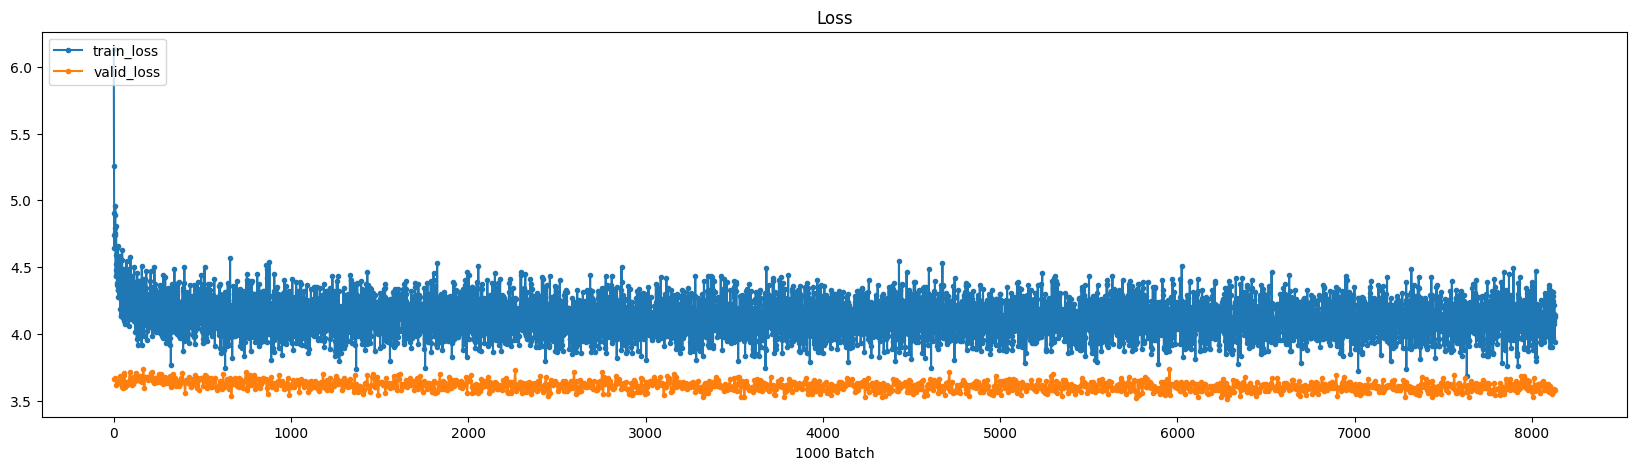

In [104]:
# loss graph
fig = plt.figure(figsize=(45, 5))
ax1 = fig.add_subplot(1, 2, 1)

train_loss_x_axis: List[int] = np.arange(len(train_loss_list)).tolist()
valid_loss_x_axis: List[int] = np.arange(start=len(train_loss_list)-1, stop=-1, step=(len(train_loss_list)/len(valid_loss_list))*-1, dtype=np.float32).astype(np.int32).tolist()[::-1]

ax1.set_title('Loss')
ax1.plot(train_loss_x_axis, train_loss_list, marker='.')
ax1.plot(valid_loss_x_axis, valid_loss_list, marker='.')
ax1.legend(['train_loss', 'valid_loss'], loc='upper left')
ax1.set_xlabel('1000 Batch')
plt.show()

In [52]:
torch.save(model, f"./models/lstm-bs{BATCH_SIZE}-lr{LEARNING_RATE}.pt")

## Testing

In [159]:
class TimeSeriesDataset(Dataset):
    def __init__(self, raw_df: pd.DataFrame, window_size: int) -> None:
        super().__init__()
        self.data: pd.DataFrame = raw_df.copy()
        self.window_size: int = window_size
        self.stock_dfs: Dict[int, pd.DataFrame]
        self.idx_map: Dict[int, Dict[str, int]]
        self.stock_dfs, self.idx_map = TimeSeriesDataset._SplitStockDataFrame(raw_df=self.data, window_size=self.window_size)
    

    def __getitem__(self, _index: int) -> Tuple[np.ndarray, np.ndarray, int, int, int]:
        '''
        return x, y, date_id, seconds_in_buckets, stock_id
        '''
        index: int = _index
        stock: int = self.idx_map[index]['stock']
        stock_idx: int = self.idx_map[index]['idx']

        start_idx, end_idx = stock_idx - (self.window_size - 1), stock_idx + 1
        return TimeSeriesDataset._GenTimeSeriesData(raw_df=self.stock_dfs[stock].iloc[start_idx:end_idx])


    def __len__(self) -> int:
        return len(self.idx_map)
    
    def FillTarget(self, stock: int, date: int, second: int, value: np.float32) -> None:
        if stock not in self.stock_dfs:
            return
        self.stock_dfs[stock].loc[(self.stock_dfs[stock]['date_id'] == date) & (self.stock_dfs[stock]['seconds_in_bucket'] == second), 'pred_target'] = value
    
    @staticmethod
    def _GenTimeSeriesData(raw_df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, int, int, int]:
        '''
        raw_df: The rows of time t-n ~ t for predicting the target of t.
        The generated features contains the data of time t-n ~ t-1.
        return x, y, date_id, seconds_in_buckets, stock_id
        '''
        df = raw_df.copy()
        df = df.sort_values(by=['date_id', 'seconds_in_bucket'], ascending=True)

        date: int = df['date_id'].tolist()[-1]
        second: int = df['seconds_in_bucket'].tolist()[-1]
        stock: int = df['stock_id'].tolist()[-1]
        y: np.float32 = df['target'].tolist()[-1]

        pred_target_not_null_indices = df['pred_target'].notnull()
        df.loc[pred_target_not_null_indices, 'target'] = df.loc[pred_target_not_null_indices, 'pred_target']
        
        df = df[MODEL_INPUT_FEATURES]
        df_numpy: np.ndarray = df.to_numpy()
        df_numpy[-1, MODEL_INPUT_FEATURES.index('target')] = 0
        
        # x: np.ndarray = df_numpy[:-1, :]
        x: np.ndarray = df_numpy
        
        return x.astype(np.float32), np.array(y).astype(np.float32), date, second, stock
    
    @staticmethod
    def _SplitStockDataFrame(raw_df: pd.DataFrame, window_size: int) -> Tuple[Dict[int, pd.DataFrame], Dict[int, Dict[str, int]]]:
        stock_dfs: Dict[int, pd.DataFrame] = {}
        idx_map: Dict[int, Dict[str, int]] = {}

        data: pd.DataFrame = raw_df.copy()
        data = data.sort_values(by=['date_id', 'seconds_in_bucket', 'stock_id'], ascending=True)
        data.reset_index(drop=True, inplace=True)
        data_idx_offset: int = 5 * 200

        for stock in data['stock_id'].unique().tolist():
            stock_df: pd.DataFrame = data.copy().loc[data['stock_id'] == stock]
            stock_df.insert(stock_df.shape[1], 'new_idx', range(stock_df.shape[0]))
            stock_df.insert(stock_df.shape[1], 'pred_target', np.nan)
            for idx, row in stock_df.iterrows():
                if row['new_idx'] < window_size:
                    continue
                stock_idx_map: Dict[str, int] = {'stock': stock, 'idx': row['new_idx']}
                idx_map[int(idx) - data_idx_offset] = stock_idx_map
            stock_df.reset_index(drop=True, inplace=True)
            stock_df.drop('new_idx', axis=1, inplace=True)
            stock_dfs[stock] = stock_df

        return stock_dfs, idx_map

In [160]:
test_dataset: TimeSeriesDataset = TimeSeriesDataset(raw_df=test_pp_df, window_size=5)

In [161]:
print(test_dataset[0])

(array([[ 0.0101214 , -1.        ,  0.998733  ,  0.14999378,  0.998383  ,
         0.998383  ,  0.998733  ,  0.01994986,  0.998908  ,  0.17002003,
         0.998805  , -1.6599894 ],
       [ 0.00991883, -1.        ,  0.998733  ,  0.1501158 ,  0.998383  ,
         0.998383  ,  0.998733  ,  0.01808234,  0.998908  ,  0.18907678,
         0.998796  , -0.23007393],
       [ 0.00991883, -1.        ,  0.998733  ,  0.1501158 ,  0.998383  ,
         0.998383  ,  0.998733  ,  0.02321076,  0.998908  ,  0.33625606,
         0.998784  ,  1.5103817 ],
       [ 0.02961175, -1.        ,  0.998996  ,  0.13825254,  0.998383  ,
         0.998383  ,  0.998908  ,  0.01906299,  0.999083  ,  0.10952274,
         0.998997  , -0.23007393],
       [ 0.02812546, -1.        ,  0.999875  ,  0.03334593,  1.        ,
         1.        ,  0.999875  ,  0.00387654,  1.00005   ,  0.00904484,
         1.        ,  0.        ]], dtype=float32), array(-5.429983, dtype=float32), 478, 0, 0)


In [97]:
# test_dataset.FillTarget(stock=0, date=477, second=540, value=np.float32(12))
# print(test_dataset[0])

(array([[ 1.0121399e-02, -1.0000000e+00,  9.9873298e-01,  1.4999378e-01,
         9.9838299e-01,  9.9838299e-01,  9.9873298e-01,  9.5575508e-03,
         9.9890798e-01,  6.2428858e-02,  9.9881601e-01, -1.9598007e+00],
       [ 1.0121399e-02, -1.0000000e+00,  9.9873298e-01,  1.4999378e-01,
         9.9838299e-01,  9.9838299e-01,  9.9873298e-01,  1.9949861e-02,
         9.9890798e-01,  1.7002003e-01,  9.9880499e-01, -1.6599894e+00],
       [ 9.9188332e-03, -1.0000000e+00,  9.9873298e-01,  1.5011580e-01,
         9.9838299e-01,  9.9838299e-01,  9.9873298e-01,  1.8082341e-02,
         9.9890798e-01,  1.8907678e-01,  9.9879599e-01, -2.3007393e-01],
       [ 9.9188332e-03, -1.0000000e+00,  9.9873298e-01,  1.5011580e-01,
         9.9838299e-01,  9.9838299e-01,  9.9873298e-01,  2.3210764e-02,
         9.9890798e-01,  3.3625606e-01,  9.9878401e-01,  1.5103817e+00],
       [ 2.9611750e-02, -1.0000000e+00,  9.9899602e-01,  1.3825254e-01,
         9.9838299e-01,  9.9838299e-01,  9.9890798e-01,  1.

In [162]:
def test(
    model, test_set: TimeSeriesDataset
) -> pd.DataFrame:
    
    result: pd.DataFrame = pd.DataFrame(columns=['date_id', 'seconds_in_bucket', 'stock_id', 'time_id', 'row_id', 'target'])

    model.eval()
    with torch.no_grad():
        with tqdm(total=len(test_set)) as pbar:
            pbar.set_description(f"Testing")
            for iter in range(len(test_set)):
                batch_x, batch_y, date, second, stock = test_set[iter]

                batch_x = torch.from_numpy(batch_x[np.newaxis, :]).to(device)
                batch_y = torch.from_numpy(batch_y).to(device)
                
                pred_y = model(batch_x).cpu().detach().numpy()

                for idx in range(len(pred_y)):
                    test_set.FillTarget(stock=stock, date=date, second=second, value=pred_y[idx])
                    curr_result: pd.DataFrame = pd.DataFrame.from_dict(data={
                        'date_id': [date], 
                        'seconds_in_bucket': [second], 
                        'stock_id': [stock], 
                        'time_id': [int(26290 + (date - 478) * 55 + second)], 
                        'row_id': [f'{date}_{second}_{stock}'], 
                        'target': [pred_y[idx][0]]
                    })
                    if result.shape[0] > 0:
                        result = pd.concat([result, curr_result], ignore_index=True)
                    else:
                        result = curr_result
                pbar.update(1)
        
    return result

In [163]:
test_result = test(model=model, test_set=test_dataset)

Testing: 100%|██████████| 33000/33000 [01:34<00:00, 350.77it/s]


In [164]:
test_result

,date_id,seconds_in_bucket,stock_id,time_id,row_id,target
0,478,0,0,26290,478_0_0,-0.601488
1,478,0,1,26290,478_0_1,-1.196316
2,478,0,2,26290,478_0_2,4.676425
3,478,0,3,26290,478_0_3,5.849753
4,478,0,4,26290,478_0_4,1.332446
...,...,...,...,...,...,...
32995,480,540,195,26940,480_540_195,-0.185602
32996,480,540,196,26940,480_540_196,-0.756889
32997,480,540,197,26940,480_540_197,0.848233
32998,480,540,198,26940,480_540_198,1.170139


In [165]:
test_out_result = test_result.sort_values(by=['date_id', 'seconds_in_bucket', 'stock_id'], ascending=True)
test_out_result.drop(['date_id', 'seconds_in_bucket', 'stock_id'], axis=1, inplace=True)
test_out_result.to_csv('./submission.csv', index=False)